In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
tf.keras.backend.clear_session()

### Datasets

In [3]:
def load_data_arrays():
    df_1 = pd.read_csv("../../datasets/1_preprocessed.csv")
    df_3 = pd.read_csv("../../datasets/3_preprocessed.csv")
    df_5 = pd.read_csv("../../datasets/5_preprocessed.csv")
    df_6 = pd.read_csv("../../datasets/6_preprocessed.csv")
    
    df = df_1.append(df_3)
    df = df.append(df_5)
    df = df.append(df_6)

    df = df[(df['is_hatespeech'] == 1)]
    df = df[(df['class'] != 0)]
    df = df[(df['class'] != 6)]
    df = df[(df['class'] != 7)]
    
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df["is_hatespeech"])
    
    return train_df, test_df

train_df, test_df = load_data_arrays()


# Convert the test- and train-DataFrames to Tensorflow Datasets

train_labels = np.eye(6)[train_df['class'].values]
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(train_df['text'].values, dtype=str), tf.string),
            tf.cast(train_labels, tf.int32)
        )
    )
)

test_labels = np.eye(6)[test_df['class'].values]
test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(test_df['text'].values, dtype=str), tf.string),
            tf.cast(test_labels, tf.int32)
        )
    )
)

BUFFER_SIZE = 1000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [4]:
print(train_dataset)
print(train_labels[0])

<PrefetchDataset shapes: ((None,), (None, 6)), types: (tf.string, tf.int32)>
[0. 1. 0. 0. 0. 0.]


### Keywords feature

In [5]:
df_kw = pd.read_csv("../../datasets/bad_words.csv")
kw_vocab = set()
for idx, item in df_kw.iterrows():
  kw_vocab.add(item[0])
kw_vocab_len = len(kw_vocab) + 1
kw_layer = tf.keras.layers.TextVectorization(vocabulary=list(kw_vocab))
kw_layer.compile()

### Encoder feature

In [6]:
VOCAB_SIZE = 750
ec_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
ec_layer.adapt(train_dataset.map(lambda text, label: text))

### Model

In [7]:
import tensorflow.keras.layers as layers

input_layer = layers.Input(shape=(1,), dtype=(tf.string))
seq_layer = kw_layer(input_layer)
seq_layer = layers.Embedding(input_dim=len(kw_layer.get_vocabulary()), output_dim=64, mask_zero=True)(seq_layer)
seq_layer = layers.Bidirectional(tf.keras.layers.LSTM(64))(seq_layer)
seq_layer = layers.Dense(64, activation='relu')(seq_layer)
seq_layer = layers.Dense(6, activation='softmax')(seq_layer)
seq2_layer = ec_layer(input_layer)
seq2_layer = layers.Embedding(input_dim=len(ec_layer.get_vocabulary()), output_dim=64, mask_zero=True)(seq2_layer)
seq2_layer = layers.Bidirectional(tf.keras.layers.LSTM(64))(seq2_layer)
seq2_layer = layers.Dense(64, activation='relu')(seq2_layer)
seq2_layer = layers.Dense(6, activation='softmax')(seq2_layer)
concat_layer = layers.Concatenate(axis=1)([seq_layer, seq2_layer])
output_layer = layers.Dense(6, activation='softmax')(concat_layer)

model = tf.keras.Model(name="hatespeech_keywords", inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=5)

Epoch 1/10
111/111 [==============================] - 28s 147ms/step - loss: 1.4825 - accuracy: 0.4038 - val_loss: 1.2970 - val_accuracy: 0.6281
Epoch 2/10
111/111 [==============================] - 13s 115ms/step - loss: 1.1950 - accuracy: 0.6859 - val_loss: 1.0262 - val_accuracy: 0.8031
Epoch 3/10
111/111 [==============================] - 13s 114ms/step - loss: 0.9571 - accuracy: 0.8077 - val_loss: 0.8723 - val_accuracy: 0.8188
Epoch 4/10
111/111 [==============================] - 12s 112ms/step - loss: 0.8429 - accuracy: 0.8182 - val_loss: 0.7796 - val_accuracy: 0.8219
Epoch 5/10
111/111 [==============================] - 12s 105ms/step - loss: 0.7634 - accuracy: 0.8259 - val_loss: 0.7228 - val_accuracy: 0.8250
Epoch 6/10
111/111 [==============================] - 12s 107ms/step - loss: 0.6872 - accuracy: 0.8366 - val_loss: 0.6710 - val_accuracy: 0.8313
Epoch 7/10
111/111 [==============================] - 12s 107ms/step - loss: 0.6341 - accuracy: 0.8428 - val_loss: 0.6169 - val_ac

In [8]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

28/28 [==============================] - 1s 42ms/step - loss: 0.5759 - accuracy: 0.8429
Test Loss: 0.5758727192878723
Test Accuracy: 0.8429054021835327


Plot the results

(0.0, 1.5308331400156021)

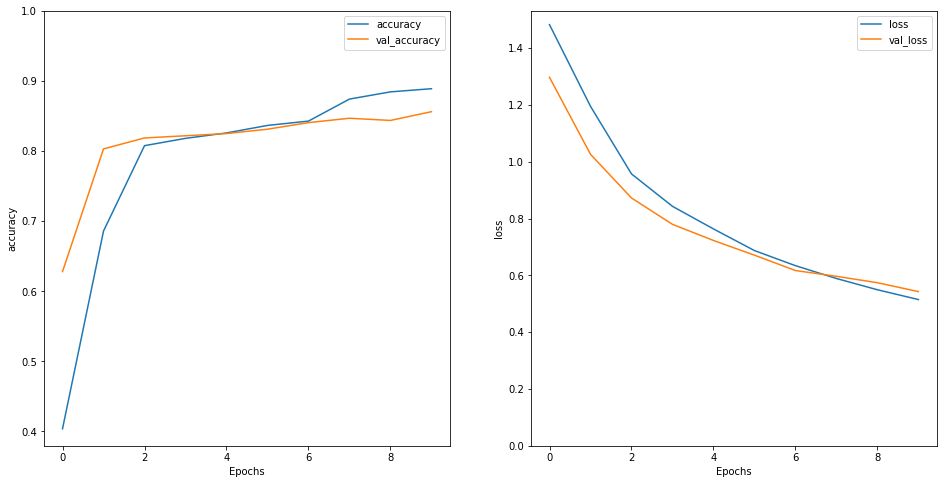

In [9]:
np.set_printoptions(precision=3, suppress=True)

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [10]:
# predict on a sample text without padding.
sample_text = ['You are such a stupid fucking whore',
               'I would not recommend this movie.',
               'You should stay in the kitchen with your emotions',
               'You can leave nigger']
predictions = model.predict(np.array(sample_text))
print(predictions)

[[0.01  0.175 0.018 0.244 0.217 0.337]
 [0.005 0.138 0.013 0.047 0.77  0.027]
 [0.011 0.825 0.016 0.012 0.122 0.014]
 [0.011 0.832 0.016 0.011 0.117 0.013]]


(Optional) Save the model

In [11]:
# model_two.save('saves/keywords')